In [1]:
import sys
sys.path.append("../SpikeCounter")
import numpy as np
import skimage.io as skio
import scipy.ndimage as ndi
import scipy.signal as signal
import scipy.stats as stats
import skimage.morphology as morphology
import matplotlib.pyplot as plt
import skimage.transform as transform
from tifffile import imsave
import scipy.ndimage as ndimage
import matplotlib.colors as colors
import matplotlib.patches as patches
import os
from scipy import interpolate, optimize
import skimage.filters as filters
import pandas as pd
from datetime import datetime
import skimage.measure as measure
from scipy.fft import fft, fftfreq, rfft
plt.style.use("../bio_pubs_presentation.mplstyle")
%matplotlib inline
import importlib

In [2]:
from spikecounter.analysis import traces, images
from spikecounter.ui import visualize
from spikecounter import utils
from sklearn.decomposition import PCA

In [3]:
def reload_libraries():
    importlib.reload(visualize)
    importlib.reload(images)
    importlib.reload(traces)

In [17]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20210724_gcamp_widefield/corrected"
expt_info = pd.read_csv(os.path.join(rootdir, "analysis", "experiment_data.csv")).sort_values("start_time").reset_index()
start_times = [datetime.strptime(t,"%H:%M:%S") for t in list(expt_info["start_time"])]
offsets = [s - start_times[0] for s in start_times]
offsets = [o.seconds for o in offsets]
expt_info["offset"] = offsets
fs = 10.2
factor = 4


In [11]:
os.makedirs(os.path.join(rootdir, "denoised/analysis"),\
            exist_ok=True)
expt_info.to_csv(os.path.join(rootdir, "denoised/analysis/experiment_data.csv"), index=False)

In [12]:
filenames = np.flip(np.array(expt_info["file_name"]))

In [28]:
f_s = fs
block_size = 375
offset = 0.01
band_threshold = 0.5
band_bounds=(0.15,2.5)
opening_size=5
dilation_size = 3
corr_threshold = 0.8

In [13]:
plt.close("all")
img = skio.imread(os.path.join(rootdir, "%s.tif" % filenames[30]))

In [14]:
filenames[30]

'102157_p1_t90_p1_z1'

In [8]:
utils.display_zstack(denoised_img[400:600], pct_cutoffs=[0,100])

interactive(children=(IntSlider(value=99, description='z', max=199), Dropdown(description='c', options=('all',…

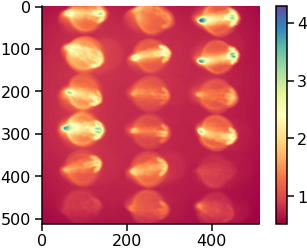

In [32]:
mean_img = img.mean(axis=0)
mean_trace = img.mean(axis=(1,2))
q = plt.imshow(mean_img)
plt.colorbar(q)

In [18]:
reload_libraries()

In [ ]:
intensity_mask, abs_power, smoothed_band_power2, initial_guesses, corr_img 

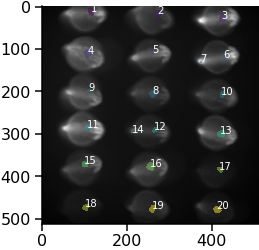

In [29]:
curr_labels, curr_coms = images.identify_hearts(\
                                            img, \
                                            opening_size=opening_size, dilation_size=dilation_size, \
                                            band_bounds=band_bounds, band_threshold=band_threshold, \
                                            f_s=fs, corr_threshold=corr_threshold, \
                                            block_size=block_size, offset=offset)

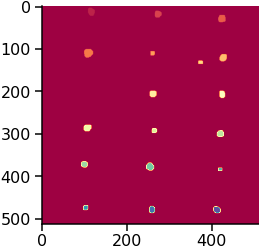

In [30]:
plt.imshow(curr_labels)

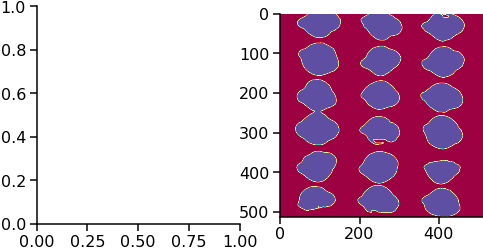

In [33]:
intensity_mask_manual = mean_img > filters.threshold_local(mean_img, block_size, offset=offset)
fig1, axes = plt.subplots(1,2, figsize=(8,4))
# axes[0].imshow(intensity_mask)
axes[1].imshow(intensity_mask_manual)

In [34]:
zeroed_image = img-mean_img
local_thresh = filters.threshold_local(mean_img, block_size=block_size, offset=offset)
# intensity_mask = mean_img > np.percentile(mean_img, intensity_threshold*100)
intensity_mask = mean_img > local_thresh

pixelwise_fft = fft(zeroed_image, axis=0)
N_samps = img.shape[0]
fft_freq = fftfreq(N_samps, 1/f_s)[:N_samps//2]
abs_power = np.abs(pixelwise_fft[:N_samps//2,:,:])**2
norm_abs_power = abs_power/np.sum(abs_power, axis=0)


In [35]:
cumsum = np.cumsum(norm_abs_power,axis=0)

In [36]:
median_power_idx = np.apply_along_axis(lambda x: np.argwhere(x>0.5).ravel()[0], 0, cumsum)

In [37]:
median_power = np.ma.masked_array(fft_freq[median_power_idx], mask=~intensity_mask)

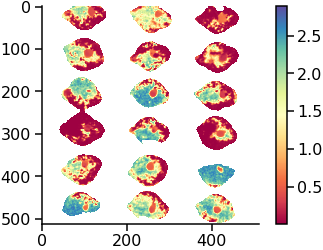

In [38]:
q = plt.imshow(median_power)
plt.colorbar(q)

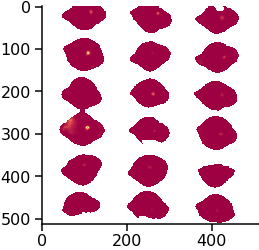

In [39]:
plt.imshow(np.ma.masked_array(np.mean(abs_power, axis=0), mask=~intensity_mask))

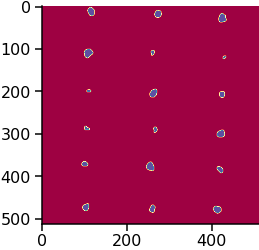

In [51]:
band_threshold=0.5
band_bounds = (0.2, 2.5)
band_power = np.sum(norm_abs_power[(fft_freq>band_bounds[0]) & (fft_freq<band_bounds[1]),:,:], axis=0)
smoothed_band_power = filters.median(band_power, footprint=np.ones((5,5)))*intensity_mask.astype(int)
processed_band_power = morphology.binary_opening((smoothed_band_power > band_threshold), footprint=np.ones((3,3)))
plt.imshow(processed_band_power)

In [52]:
initial_guesses = measure.label(processed_band_power)

In [53]:
bboxes = [p["bbox"] for p in measure.regionprops(initial_guesses)]
new_mask = np.zeros_like(mean_img, dtype=bool)
#     new_mask_labels = np.deepcopy(initial_guesses)
n_rois = np.max(initial_guesses)
corr_img = np.zeros((n_rois, mean_img.shape[0], mean_img.shape[1]), dtype=float)


In [54]:
bbox_offset=5
for i in range(1, n_rois+1):
    bbox = bboxes[i-1]
    r1 = max(bbox[0]-bbox_offset, 0)
    c1 = max(bbox[1]-bbox_offset, 0)
    r2 = min(bbox[2]+bbox_offset, initial_guesses.shape[0])
    c2 = min(bbox[3]+bbox_offset, initial_guesses.shape[1])
#         print(r1,r2,c1,c2)
    roi_mask = np.zeros_like(initial_guesses, dtype=bool)
    roi_mask[r1:r2, c1:c2] = 1    
    initial_trace = images.extract_mask_trace(zeroed_image, mask = roi_mask)
    roi_traces = zeroed_image[:,roi_mask]
#         print(roi_traces.shape)
    corrs = np.apply_along_axis(lambda x: stats.pearsonr(initial_trace, x)[0], 0, roi_traces)
    corrs = corrs.reshape((r2-r1, c2-c1))
    corr_img[i-1, r1:r2, c1:c2] = corrs

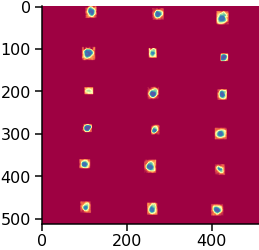

In [55]:
plt.imshow(corr_img.max(axis=0))

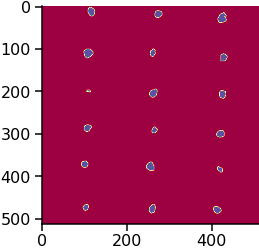

In [58]:
plt.imshow(corr_img.max(axis=0) > 0.6)

In [34]:
for i in np.arange(labels.max())+1:
    print(i, np.mean(smoothed_band_power[labels==i]))

1 0.753135376619634
2 0.6806502958157856
3 0.47350992642448414
4 0.6940207829303442
5 0.7379837760313139
6 0.5702381642276811
7 0.5841424442225697
8 0.4663434885923864
9 0.5115455025131954
10 0.5496208147314483
11 0.7273187985082921
12 0.5894589216304644
13 0.6805860034636597
14 0.6500936215150989
15 0.6182655122195237
16 0.7322687614187573
17 0.47376755115031555
18 0.6601245839578945
19 0.685607899649221
20 0.6468291065831501
21 0.6684830334539291
22 0.6780824271295282
23 0.6630454731004765


(<Figure size 720x864 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x2b09e23a9af0>)

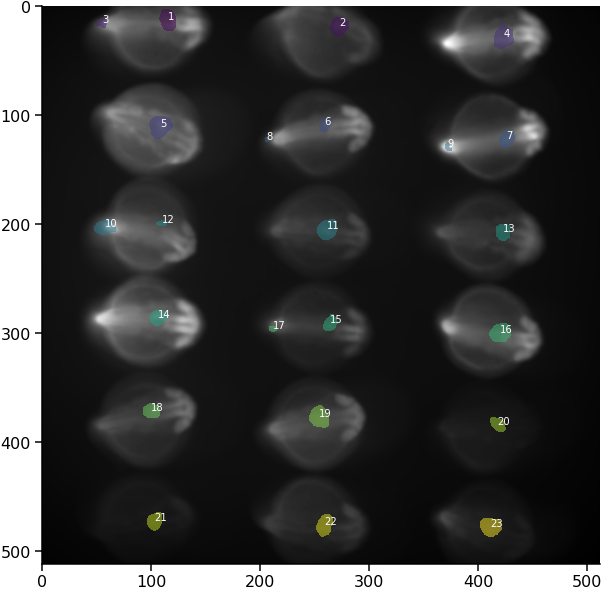

In [32]:
visualize.display_roi_overlay(mean_img, labels)

In [20]:
f_s = fs
block_size = 375
offset = 0.01
band_threshold = 0.52
band_bounds=(0.15,2.5)
opening_size=5
dilation_size = 3
corr_threshold = 0.8

In [21]:
reload_libraries()

In [23]:
expt_info = pd.read_csv(expt_info_path).sort_values("start_time").reset_index()

120
['/n/holyscratch01/cohen_lab/bjia/20210724_gcamp_widefield/corrected/102356_p1_t91_p1_z1.tif']


/tmp/ipykernel_38742/2750398325.py:21: UserWarning: /n/holyscratch01/cohen_lab/bjia/20210724_gcamp_widefield/corrected/analysis/unlinked_segmentation_video.tif is a low contrast image
  skio.imsave(os.path.join(data_folder, "analysis", "unlinked_segmentation_video.tif"), vid)


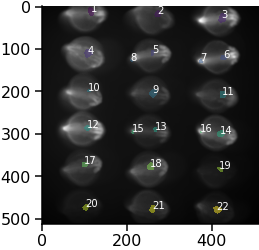

In [26]:

expt_info_path = "/n/holyscratch01/cohen_lab/bjia/20210724_gcamp_widefield/corrected/analysis/experiment_data.csv"
data_folder = "/n/holyscratch01/cohen_lab/bjia/20210724_gcamp_widefield/corrected/"
expt_info = pd.read_csv(expt_info_path).sort_values("start_time").reset_index()

filenames = expt_info["file_name"].tolist()
print(len(filenames))

# if end_idx == 0:
#     filenames = filenames[args.start_idx:len(filenames)]
# else:
#     filenames = filenames[args.start_idx:args.end_idx+1]
filenames = filenames[-30:-29]

pathnames = [os.path.join(data_folder, "%s.tif" % f) for f in filenames]
print(pathnames)
vid, exclude_from_write = images.segment_widefield_series(pathnames, \
                                      f_s=f_s, band_bounds=band_bounds, opening_size=opening_size,\
                                     dilation_size=dilation_size, band_threshold=band_threshold,\
                                      block_size=block_size, offset=offset, corr_threshold=corr_threshold)
os.makedirs(os.path.join(data_folder, "analysis"), exist_ok=True)
skio.imsave(os.path.join(data_folder, "analysis", "unlinked_segmentation_video.tif"), vid)
linked_vid = images.link_stack(vid)


### Manually link videos

In [59]:
autoseg_video = skio.imread(os.path.join(rootdir, "denoised/analysis", "segmentation_video.tif"))

In [60]:
utils.display_zstack(autoseg_video, pct_cutoffs=[0,100])

interactive(children=(IntSlider(value=63, description='z', max=127), Dropdown(description='c', options=('all',…

In [16]:
vid = skio.imread(os.path.join(rootdir, "denoised/analysis", \
                                          "unlinked_segmentation_video.tif"))

In [17]:
utils.display_zstack(vid, pct_cutoffs=[0,100])

interactive(children=(IntSlider(value=44, description='z', max=89), Dropdown(description='c', options=('all', …

In [21]:
linked_vid = link_stack(vid)

filtered_vid = filter_by_appearances(linked_vid, vid, threshold = 0.03)
filled_vid = fill_missing(filtered_vid)
forward_time_vid = np.flip(filled_vid, axis=0)

In [22]:
utils.display_zstack(forward_time_vid, pct_cutoffs=[0,100])

interactive(children=(IntSlider(value=44, description='z', max=89), Dropdown(description='c', options=('all', …

In [23]:
skio.imsave(os.path.join(rootdir, "denoised/analysis", "segmentation_video.tif"), forward_time_vid)


/tmp/ipykernel_100453/3341719579.py:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220216_endogenous_activity_nkxzsy/denoised/analysis/segmentation_video.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "denoised/analysis", "segmentation_video.tif"), forward_time_vid)


In [26]:
for i in range(forward_time_vid.shape[0]):
    f = expt_info["file_name"].iloc[i]
    skio.imsave(os.path.join(rootdir, "denoised/analysis", "automasks/%s_mask.tif" % f), forward_time_vid[i,:,:])

/tmp/ipykernel_100453/1699935631.py:3: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220216_endogenous_activity_nkxzsy/denoised/analysis/automasks/091621_p1_t1_p1_z1_mask.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "denoised/analysis", "automasks/%s_mask.tif" % f), forward_time_vid[i,:,:])
/tmp/ipykernel_100453/1699935631.py:3: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220216_endogenous_activity_nkxzsy/denoised/analysis/automasks/091820_p1_t2_p1_z1_mask.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "denoised/analysis", "automasks/%s_mask.tif" % f), forward_time_vid[i,:,:])
/tmp/ipykernel_100453/1699935631.py:3: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220216_endogenous_activity_nkxzsy/denoised/analysis/automasks/092019_p1_t3_p1_z1_mask.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "denoised/analysis", "automasks/%s_mask.tif" % f), forward_time_vid[i,:,:])
/tmp/ipykernel_100453/1699935631.py:3: UserWarning: /n/holyscrat

/tmp/ipykernel_100453/1699935631.py:3: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220216_endogenous_activity_nkxzsy/denoised/analysis/automasks/102605_p1_t5_p1_z1_mask.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "denoised/analysis", "automasks/%s_mask.tif" % f), forward_time_vid[i,:,:])
/tmp/ipykernel_100453/1699935631.py:3: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220216_endogenous_activity_nkxzsy/denoised/analysis/automasks/102804_p1_t6_p1_z1_mask.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "denoised/analysis", "automasks/%s_mask.tif" % f), forward_time_vid[i,:,:])
/tmp/ipykernel_100453/1699935631.py:3: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220216_endogenous_activity_nkxzsy/denoised/analysis/automasks/103003_p1_t7_p1_z1_mask.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "denoised/analysis", "automasks/%s_mask.tif" % f), forward_time_vid[i,:,:])
/tmp/ipykernel_100453/1699935631.py:3: UserWarning: /n/holyscrat

/tmp/ipykernel_100453/1699935631.py:3: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220216_endogenous_activity_nkxzsy/denoised/analysis/automasks/113416_p1_t9_p1_z1_mask.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "denoised/analysis", "automasks/%s_mask.tif" % f), forward_time_vid[i,:,:])
/tmp/ipykernel_100453/1699935631.py:3: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220216_endogenous_activity_nkxzsy/denoised/analysis/automasks/113615_p1_t10_p1_z1_mask.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "denoised/analysis", "automasks/%s_mask.tif" % f), forward_time_vid[i,:,:])
/tmp/ipykernel_100453/1699935631.py:3: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220216_endogenous_activity_nkxzsy/denoised/analysis/automasks/113814_p1_t11_p1_z1_mask.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "denoised/analysis", "automasks/%s_mask.tif" % f), forward_time_vid[i,:,:])
/tmp/ipykernel_100453/1699935631.py:3: UserWarning: /n/holyscr